In [1]:
import pandas as pd
from causalml.propensity import GradientBoostedPropensityModel
from causalml.propensity import LogisticRegressionPropensityModel
from helpers import GradientBoostedPropensityModelContinuous
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu

In [2]:
cancer_data = pd.read_excel("../data/rise_cancer_data.xlsx")
all_patients = pd.read_csv("../data/rise_all_data.csv")
all_patients["cancer"] = all_patients["participantid"].isin(cancer_data["participantid"])

cancer_patients = all_patients[all_patients["cancer"]]


confounders = [
    "b1_e3", "b1_e6", "b1_e7", "b1_e8a", "b1_e8b", "b1_e8c", "b1_e8d", "b1_e8e", "b1_e8f", "b1_e8g", "b1_e8h",
    "b1_e8i", "b1_e8j", "b1_e9a", "b1_e9b", "b1_e9c", "b1_e9d", "b1_e9e", "b1_e9f", "b1_e9g", "b1_e9h",
    "b1_e10a", "b1_e10b", "b1_e10c", "b1_e10d", "b1_e10e", "b1_e10f", "b1_e10g", "b1_e10h", "b1_e10i",
    "b1_e12a", "b1_e12b", "b1_e12c", "b1_e12d", "b1_e12e", "b1_e12f", "b1_e12g", "b1_e12h", "b1_e12i",
    "b1_e15a", "b1_e15b", "b1_e15c", "b1_e15d", "b1_e15e", "b1_e15f", "b1_e16a", "b1_e17", "b1_e17a_1",
    "b1_e17a_2", "b1_e17c", "b1_e17d", "b1_e17e", "b1_e19", "b1_lurn1", "b1_lurn2", "b1_lurn3", "b1_lurn4",
    "b1_lurn5", "b1_lurn6", "b1_lurn7", "b1_lurn8", "b1_lurn11", "b1_e22", "b1_f5", "b1_f6a", "b1_f6b",
    "b1_f6c", "b1_f6d", "b1_f6e", "b1_f6f", "b1_f6g", "b1_f6h", "b1_f12", "b1_f12b_y", "b1_f12b_m", "b1_f14",
    "b1_f15", "b1_f16", "b1_f17", "b1_f18a", "b1_f18b", "b1_f18c", "b1_f18d", "b1_f18e", "b1_f20", "b1_f20a",
    "b1_f22a", "b1_f22b", "b1_f22c", "b1_f22d", "b1_f23", "b1_f24", "b1_f25", "b1_f26", "b1_f27",
    "age_impute", "pregnant", "sex_at_birth", "height", "weight", "bmi", "birth_control",
    "vaginal_parity", "deliveries_cesarean_6lvl", "deliveries_vaginal_6lvl"
]



categorical_confounders = [
    "b1_e1", "b1_e2", 
    "b1_e16", "b1_e20", "b1_f1", "b1_f4", "b1_f13a", "b1_f14a", "b1_f19", "b1_f28",
    "race", "menopause_impute", "gender", "education", "employment"
]

outcomes = [
    "bhs_1", "bhs_2", "bhs_3", "bhs_4", "bhs_5", "bhs_6", "bhs_7", "bhs_8", "bhs_9", "bhs_10",
    "bfi_biosis", "bfi_freq", "bfi_sensation", "bfi_continence", "bfi_comfort", "bfi_emptying"
]

filtered_labels = {
    # Health insurance and healthcare access
    "b1_e2_0.0": "No usual healthcare place for checkups",
    "b1_e2_1.0": "Multiple healthcare places for checkups",
    "b1_e2_2.0": "One healthcare place for checkups",
    "b1_f6a": "Health insurance status",
    "b1_f6b": "Private insurance",
    "b1_f6c": "Medicaid coverage",
    "b1_f6d": "Medicare coverage",
    "b1_f6e": "Supplemental insurance",
    "b1_f6f": "Military insurance",
    "b1_f6g": "VA coverage",
    
    # Demographics and personal characteristics
    "b1_e1": "Age",
    "b1_e4_in": "Height (feet)",
    "b1_e4_cm": "Height (inches)",
    "b1_e5_lbs": "Weight (lbs)",
    "b1_e5_kg": "Weight (kg)",
    "b1_f1_1": "Married",
    "b1_f1_2": "Widowed",
    "b1_f1_3": "Unmarried, living with partner",
    "b1_f1_4": "Divorced",
    "b1_f1_5": "Separated",
    "b1_f1_6": "Single, never married",
    "b1_f1_7": "Other marital status",
    "b1_f2o": "Sex assigned at birth",
    "b1_f4_1.0": "Woman",
    "b1_f4_2.0": "Man",
    "b1_f4_3.0": "Non-binary",
    "b1_f4_4.0": "Transgender man",
    "b1_f4_5.0": "Transgender woman",
    "gender_1.0": "Female gender identity",
    "gender_2.0": "Male gender identity",
    "gender_3.0": "Non-binary gender identity",
    "gender_7.0": "Gender non-conforming identity",
    "gender_8.0": "Agender identity",
    "b1_f8": "Education level",
    
    # Employment
    "b1_f13a": "Employment status",
    "b1_f13a_10.0": "Healthcare Practitioner job",
    "b1_f13a_8.0": "Educational/Instructional job",
    
    # Housing and transportation
    "b1_f19o": "Housing type",
    "b1_f20": "Other housing text",
    "b1_f22b": "Homelessness history",
    "b1_f22c": "Shelter stay history",
    "b1_f23": "Doubled-up housing",
    "b1_f24": "Transportation barriers to healthcare",
    
    # Health conditions
    "b1_e8b": "Diabetes diagnosis",
    "b1_e8c": "Hypertension diagnosis",
    "b1_e8d": "Heart condition diagnosis",
    "b1_e8e": "Respiratory condition diagnosis",
    "b1_e8f": "Osteoarthritis diagnosis",
    "b1_e8g1": "Sleep apnea diagnosis",
    "b1_e8h": "Sleep apnea equipment use",
    "b1_e9a": "Depression diagnosis",
    "b1_e9b": "Stroke history",
    "b1_e9d": "MS diagnosis",
    "b1_e9e": "Parkinson's diagnosis",
    "b1_e9f": "Brain/spinal injury history",
    "b1_e9h": "Spinal condition diagnosis",
    "b1_e10e": "Pelvic injury history",
    "b1_e10g": "Chronic pain diagnosis",
    "b1_e10i": "PCOS diagnosis",
    
    # Women's health
    "b1_e12d1": "Hysterectomy history",
    "b1_e12e": "Hysterectomy age",
    "b1_e12f": "Oophorectomy history",
    "b1_e12h": "Hemorrhoid surgery history",
    "b1_e12d": "Kidney transplant history",
    "b1_e17": "Current pregnancy",
    "b1_e17a_1": "Parity",
    "b1_e17a_2": "C-section count",
    "b1_e17a1_lb": "Vaginal delivery count",
    "b1_e17c": "Last birth details",
    "b1_e15c": "HRT use",
    "b1_e15a1": "Vaginal estrogen use",
    "b1_e16_1.0": "Pre-menopausal",
    "b1_e16_2.0": "Peri-menopausal",
    "b1_e16_3.0": "Post-menopausal",
    "b1_e16_88.0": "Menopausal status unknown",
    "b1_e16a": "Menopausal status",
    "b1_e16a1a": "Current birth control use",
    "menopause_impute_1": "Imputed pre-menopausal",
    "menopause_impute_2": "Imputed peri-menopausal",
    "menopause_impute_3": "Imputed post-menopausal",
    "menopause_impute_88": "Imputed menopausal status unknown",
    
    # Mental health
    "b1_f28": "Anxiety level",
    "b1_f28_3.0": "Moderate anxiety",
    "b1_f28_4.0": "High anxiety",
    "b1_f28_5.0": "Very high anxiety",
    
    # Substance use
    "b1_e20_0.0": "Never smoked (or <100 cigarettes)",
    "b1_e20_1.0": "Former smoker (≥100 cigarettes)",
    "b1_e20_2.0": "Current smoker (≥100 cigarettes)",
    "b1_lurn1": "Current smoking status",
    
    # Food security
    "b1_f26": "Food insecurity - worry",
    "b1_f27": "Food insecurity - shortage",
    
    # Discrimination (overarching)
    "b1_f18b": "Discrimination frequency - courtesy",
    "b1_f18a": "Financial security"
}


# One hot encoding categorical confounders
def one_hot_encode(df, columns):
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df.drop(column, axis=1, inplace=True)
    return df

all_patients_confounders = all_patients[confounders + categorical_confounders]
all_patients_confounders = one_hot_encode(all_patients_confounders, categorical_confounders)

# Drop columns where at least half of the values are missing
missing_threshold = len(all_patients_confounders) / 2
all_patients_confounders = all_patients_confounders.dropna(thresh=missing_threshold, axis=1)

# Impute zeros for missing values
all_patients_confounders = all_patients_confounders.fillna(0)
all_patients_confounders["deliveries_cesarean_6lvl"] = all_patients_confounders["deliveries_cesarean_6lvl"].apply(lambda x : 5 if "5" in str(x) else x).astype(int)
all_patients_confounders["deliveries_vaginal_6lvl"] = all_patients_confounders["deliveries_vaginal_6lvl"].apply(lambda x : 5 if "5" in str(x) else x).astype(int)
all_patients_confounders = all_patients_confounders[all_patients_confounders.columns.intersection(list(filtered_labels.keys()))]
all_patients_confounders_matrix = all_patients_confounders.values
exposures = all_patients["cancer"].values

In [4]:
variable_labels = {
    "b1_age": "Participant Age",
    "b1_e1": "Age",
    "b1_e2": "Primary healthcare place for sickness",
    "b1_e3": "Primary healthcare place for checkups",
    "b1_e4_ft": "Time since last doctor visit",
    "b1_e4_in": "Height (feet)",
    "b1_e4_cm": "Height (inches)",
    "b1_e5_lbs": "Weight (cm)",
    "b1_e5_kg": "Weight (lbs)",
    "b1_e6": "Weight (kg)",
    "b1_e7": "Toilet assistance needed",
    "b1_e8a": "Toilet accessibility difficulty",
    "b1_e8b": "Diabetes diagnosis",
    "b1_e8c": "Hypertension diagnosis",
    "b1_e8d": "Heart condition diagnosis",
    "b1_e8e": "Respiratory condition diagnosis",
    "b1_e8f": "Osteoarthritis diagnosis",
    "b1_e8f1": "Inflammatory arthritis diagnosis",
    "b1_e8f2": "Hip arthritis",
    "b1_e8g": "Knee arthritis",
    "b1_e8g1": "Sleep apnea diagnosis",
    "b1_e8h": "Sleep apnea equipment use",
    "b1_e8h1": "Kidney failure diagnosis",
    "b1_e8i": "Dialysis treatment",
    "b1_e8j": "Anxiety diagnosis",
    "b1_e9a": "Depression diagnosis",
    "b1_e9b": "Stroke history",
    "b1_e9c": "Mini-stroke history",
    "b1_e9d": "MS diagnosis",
    "b1_e9e": "Parkinson's diagnosis",
    "b1_e9f": "Brain/spinal injury history",
    "b1_e9g": "Spina bifida diagnosis",
    "b1_e9h": "Spinal condition diagnosis",
    "b1_e10a": "Cognitive impairment",
    "b1_e10b": "Neurogenic bladder diagnosis",
    "b1_e10c": "Childhood bladder surgery",
    "b1_e10d": "Vaginal prolapse",
    "b1_e10e": "Pelvic injury history",
    "b1_e10e1": "Interstitial cystitis diagnosis",
    "b1_e10f": "Interstitial cystitis treatment",
    "b1_e10g": "Chronic pain diagnosis",
    "b1_e10h": "Uterine fibroids diagnosis",
    "b1_e10i": "PCOS diagnosis",
    "b1_e11": "Bowel condition diagnosis",
    "b1_e11a": "Cancer history",
    "b1_e11a1": "Bladder cancer history",
    "b1_e11a2": "Bladder removal history",
    "b1_e11b": "Bladder cancer treatment history",
    "b1_e11c": "Uterine cancer history",
    "b1_e11d": "Cervical cancer history",
    "b1_e11e": "Ovarian cancer history",
    "b1_e11f": "Colorectal cancer history",
    "b1_e11g": "Pelvic radiation history",
    "b1_e11g1": "Breast cancer history",
    "b1_e12a": "Anti-estrogen medication use",
    "b1_e12b": "Prolapse surgery history",
    "b1_e12c": "Kidney removal history",
    "b1_e12d": "Kidney transplant history",
    "b1_e12d1": "Hysterectomy history",
    "b1_e12e": "Hysterectomy age",
    "b1_e12f": "Oophorectomy history",
    "b1_e12g": "Colectomy history",
    "b1_e12h": "Hemorrhoid surgery history",
    "b1_e12i": "Incontinence surgery history",
    "b1_e13": "Urethral surgery history",
    "b1_e14a": "Bladder concerns discussion",
    "b1_e14b": "Pessary use history",
    "b1_e14c": "Bladder Botox treatment",
    "b1_e14c1": "Bladder neuromodulation history",
    "b1_e14c2": "Neuromodulation for urgency",
    "b1_e14d": "Neuromodulation for retention",
    "b1_e14d1": "Kegel exercises history",
    "b1_e14e": "Professional-guided Kegels",
    "b1_e14f": "Alternative bladder treatments",
    "b1_e14g": "Chronic catheter use",
    "b1_e15a": "Self-catheterization history",
    "b1_e15a1": "Vaginal estrogen use",
    "b1_e15a2": "Estrogen for dryness",
    "b1_e15a3": "Estrogen for dyspareunia",
    "b1_e15a4": "Estrogen for urgency",
    "b1_e15a5": "Estrogen for UTI prevention",
    "b1_e15a6": "Estrogen for other reasons",
    "b1_e15b": "Estrogen use reason unknown",
    "b1_e15c": "HRT use",
    "b1_e15d": "Bladder medication use",
    "b1_e15e": "Prophylactic antibiotics",
    "b1_e15f": "OTC UTI treatments",
    "b1_e16": "Diuretic use",
    "b1_e16a": "Menopausal status",
    "b1_e16a1a": "Current birth control use",
    "b1_e16a1a1": "Oral contraceptive use",
    "b1_e16a1b": "Continuous oral contraceptive use",
    "b1_e16a1c": "Vaginal ring use",
    "b1_e16a1d": "Contraceptive patch use",
    "b1_e16a1e": "Contraceptive implant use",
    "b1_e16a1f": "Hormonal IUD use",
    "b1_e16a1g": "Copper IUD use",
    "b1_e16a1h": "Condom use",
    "b1_e16a1i": "Diaphragm use",
    "b1_e16b": "Spermicide use",
    "b1_e17": "Current pregnancy",
    "b1_e17a_1": "Parity",
    "b1_e17a_2": "C-section count",
    "b1_e17a1_lb": "Vaginal delivery count",
    "b1_e17a1_oz": "Baby weight (lbs)",
    "b1_e17a1_gr": "Baby weight (oz)",
    "b1_e17a2a": "Baby weight (grams)",
    "b1_e17a2b": "Forceps delivery",
    "b1_e17a2c": "Vacuum delivery",
    "b1_e17a2d": "Episiotomy history",
    "b1_e17b_1": "Severe perineal tear history",
    "b1_e17b_2": "First birth details",
    "b1_e17c": "Last birth details",
    "b1_e17c1_m": "Recent birth (<1 year)",
    "b1_e17c1_y": "Birth month",
    "b1_e17d": "Birth year",
    "b1_e17e": "Current breastfeeding",
    "b1_e17e1_m": "Recent breastfeeding",
    "b1_e17e1_y": "Breastfeeding month",
    "b1_e18": "Breastfeeding year",
    "b1_e19": "Sexual activity frequency",
    "b1_e20": "Smoking history",
    "b1_lurn1": "Current smoking status",
    "b1_lurn2": "Urinary urgency frequency",
    "b1_lurn3": "Urge incontinence frequency",
    "b1_lurn4": "Stress incontinence frequency",
    "b1_lurn5": "Activity incontinence frequency",
    "b1_lurn6": "Bladder pain frequency",
    "b1_lurn7": "Urinary hesitancy frequency",
    "b1_lurn8": "Weak stream frequency",
    "b1_lurn9": "Post-void dribbling frequency",
    "b1_lurn10": "LURN symptom score part 1",
    "b1_lurn11": "LURN symptom score part 2",
    "lurnscore": "Urinary symptom bother",
    "b1_e22": "LURN total score",
    "b1_f1": "Incomplete emptying frequency",
    "b1_f2o_2": "Marital status",
    "b1_f2": "Other marital status text",
    "b1_f2o": "Sex assigned at birth",
    "b1_f3": "Other sex text",
    "b1_f3o": "Gender identity",
    "b1_f4": "Other gender text",
    "b1_f4o": "Sexual orientation",
    "b1_f5": "Other orientation text",
    "b1_f6a": "Health insurance status",
    "b1_f6b": "Private insurance",
    "b1_f6c": "Medicaid coverage",
    "b1_f6d": "Medicare coverage",
    "b1_f6e": "Supplemental insurance",
    "b1_f6f": "Military insurance",
    "b1_f6g": "VA coverage",
    "b1_f6h": "IHS coverage",
    "b1_f6o": "Other insurance",
    "b1_f7": "Other insurance text",
    "b1_f8": "Education level",
    "b1_f9": "Ancestry/ethnic origin",
    "b1_f9o": "Hispanic origin",
    "b1_f10": "Other origin text",
    "b1_f10o1": "Race/ethnicity",
    "b1_f10o2": "Tribal affiliation",
    "b1_f11": "Other race text",
    "b1_f11o": "Home languages",
    "b1_f11a": "Other language text",
    "b1_f11ao": "Primary home language",
    "b1_f12": "Other primary language text",
    "b1_f12a": "US born",
    "b1_f12b_y": "Birth country",
    "b1_f12b_m": "US residence years",
    "b1_f13": "US residence months",
    "b1_f13a": "Employment status",
    "b1_f13a_span": "Job category",
    "b1_f13b_y": "Job title",
    "b1_f13b_m": "Current job years",
    "b1_f14": "Current job months",
    "b1_f14a": "Employment history",
    "b1_f14a_span": "Previous job category",
    "b1_f14b_m": "Previous job title",
    "b1_f14b_y": "Previous job months",
    "b1_f14c": "Previous job years",
    "b1_f15": "Work end year",
    "b1_f16": "Household size",
    "b1_f17": "Income bracket",
    "b1_f18a": "Financial security",
    "b1_f18b": "Discrimination frequency - courtesy",
    "b1_f18c": "Discrimination frequency - service",
    "b1_f18d": "Discrimination frequency - intelligence",
    "b1_f18e": "Discrimination frequency - fear",
    "b1_f18_a": "Discrimination frequency - threats",
    "b1_f18o": "Discrimination reasons",
    "b1_f19": "Other discrimination text",
    "b1_f19o": "Housing type",
    "b1_f20": "Other housing text",
    "b1_f20a": "Current residence duration",
    "b1_f21": "Recent moves count",
    "b1_f22a": "Zip code",
    "b1_f22b": "Homelessness history",
    "b1_f22c": "Shelter stay history",
    "b1_f22d": "Transitional housing history",
    "b1_f23": "Doubled-up housing",
    "b1_f24": "Transportation barriers to healthcare",
    "b1_f25": "Transportation barriers to daily life",
    "b1_f26": "Food insecurity - worry",
    "b1_f27": "Food insecurity - shortage",
    "b1_f28": "Anxiety level",
    "baseline1_date": "Military service history"
}

variable_labels.update({
    "b1_e1_0.0": "No usual healthcare place for sickness",
    "b1_e1_1.0": "Multiple healthcare places for sickness",
    "b1_e1_2.0": "One healthcare place for sickness",
    "b1_e2_0.0": "No usual healthcare place for checkups",
    "b1_e2_1.0": "Multiple healthcare places for checkups",
    "b1_e2_2.0": "One healthcare place for checkups",
    "b1_e16_1.0": "Pre-menopausal",
    "b1_e16_2.0": "Peri-menopausal",
    "b1_e16_3.0": "Post-menopausal",
    "b1_e16_88.0": "Menopausal status unknown",
    "b1_e20_0.0": "Never smoked (or <100 cigarettes)",
    "b1_e20_1.0": "Former smoker (≥100 cigarettes)",
    "b1_e20_2.0": "Current smoker (≥100 cigarettes)",
    "b1_f1_1": "Married",
    "b1_f1_2": "Widowed",
    "b1_f1_3": "Unmarried, living with partner",
    "b1_f1_4": "Divorced",
    "b1_f1_5": "Separated",
    "b1_f1_6": "Single, never married",
    "b1_f1_7": "Other marital status",
    "b1_f4_1.0": "Woman",
    "b1_f4_2.0": "Man",
    "b1_f4_3.0": "Non-binary",
    "b1_f4_4.0": "Transgender man",
    "b1_f4_5.0": "Transgender woman",
    "b1_f13a_1.0": "Management job",
    "b1_f13a_2.0": "Business/Financial job",
    "b1_f13a_3.0": "Computer/Mathematical job",
    "b1_f13a_4.0": "Architecture/Engineering job",
    "b1_f13a_5.0": "Life/Physical/Social Science job",
    "b1_f13a_6.0": "Community/Social Service job",
    "b1_f13a_7.0": "Legal job",
    "b1_f13a_8.0": "Educational/Instructional job",
    "b1_f13a_9.0": "Arts/Design/Entertainment job",
    "b1_f13a_10.0": "Healthcare Practitioner job",
    "b1_f13a_11.0": "Healthcare Support job",
    "b1_f13a_12.0": "Protective Service job",
    "b1_f13a_13.0": "Food Preparation job",
    "b1_f13a_15.0": "Personal Care job",
    "b1_f13a_16.0": "Sales job",
    "b1_f13a_17.0": "Office/Administrative job",
    "b1_f13a_18.0": "Farming/Fishing/Forestry job",
    "b1_f13a_20.0": "Installation/Maintenance job",
    "b1_f13a_21.0": "Production job",
    "b1_f13a_22.0": "Transportation job",
    "b1_f14a_1.0": "Previous job - Management",
    "b1_f14a_2.0": "Previous job - Business/Financial",
    "b1_f14a_3.0": "Previous job - Computer/Mathematical",
    "b1_f14a_5.0": "Previous job - Science",
    "b1_f14a_6.0": "Previous job - Community/Social Service",
    "b1_f14a_7.0": "Previous job - Legal",
    "b1_f14a_8.0": "Previous job - Educational",
    "b1_f14a_9.0": "Previous job - Arts/Design",
    "b1_f14a_10.0": "Previous job - Healthcare Practitioner",
    "b1_f14a_11.0": "Previous job - Healthcare Support",
    "b1_f14a_15.0": "Previous job - Personal Care",
    "b1_f14a_16.0": "Previous job - Sales",
    "b1_f14a_17.0": "Previous job - Office/Administrative",
    "b1_f14a_18.0": "Previous job - Farming/Fishing/Forestry",
    "b1_f14a_21.0": "Previous job - Production",
    "b1_f14a_22.0": "Previous job - Transportation",
    "b1_f19_1.0": "Discrimination due to race/ethnicity",
    "b1_f19_2.0": "Discrimination due to gender identity",
    "b1_f19_3.0": "Discrimination due to sexual orientation",
    "b1_f19_4.0": "Discrimination due to education/income",
    "b1_f19_5.0": "Discrimination due to other reasons",
    "b1_f19_6.0": "Discrimination due to unknown reasons",
    "b1_f19_7.0": "Discrimination due to multiple reasons",
    "b1_f19_8.0": "Discrimination due to unspecified reasons",
    "b1_f28_3.0": "Moderate anxiety",
    "b1_f28_4.0": "High anxiety",
    "b1_f28_5.0": "Very high anxiety",
    "menopause_impute_1": "Imputed pre-menopausal",
    "menopause_impute_2": "Imputed peri-menopausal",
    "menopause_impute_3": "Imputed post-menopausal",
    "menopause_impute_88": "Imputed menopausal status unknown",
    "gender_1.0": "Female gender identity",
    "gender_2.0": "Male gender identity",
    "gender_3.0": "Non-binary gender identity",
    "gender_7.0": "Gender non-conforming identity",
    "gender_8.0": "Agender identity"
})

In [6]:
all_patients_confounders_p_vals = []

for i, column in enumerate(all_patients_confounders.columns):
    column_data = all_patients_confounders[column].values
    stat, p = mannwhitneyu(all_patients_confounders[column][exposures].values.astype(float), all_patients_confounders[column][~exposures].values.astype(float))
    all_patients_confounders_p_vals.append((column, p))

# argsort by p-value
all_patients_confounders_p_vals = sorted(all_patients_confounders_p_vals, key=lambda x: x[1])

# Get list of sorted columns
sorted_columns = [x[0] for x in all_patients_confounders_p_vals]

In [8]:
fig, axs = plt.subplots(10, 20, figsize=(80, 40), dpi=300)
# Loop through each category in all_patients_confounders

axs = axs.flatten()
for i, column in enumerate(sorted_columns):
    # Get the column data
    column_data = all_patients_confounders[column].values

    # Create a scatter plot in the corresponding subplot
    ax = axs[i]
    sns.stripplot(all_patients_confounders[column][exposures].values.astype(float), ax=ax, label="Cancer", color="red")
    sns.stripplot(all_patients_confounders[column][exposures].values.astype(float), ax=ax, label="No Cancer", color="green")
    # Display Mann Whitney Statistic on the plot
    stat, p = mannwhitneyu(all_patients_confounders[column][exposures].values.astype(float), all_patients_confounders[column][~exposures].values.astype(float))
    ax.annotate(f"U={stat:.2f}, p={p:.2e}", xy=(0.5, 0.9), xycoords='axes fraction', ha='center', fontsize=8)

    #sns.stripplot(all_patients_confounders[column][~exposures].values.astype(float), axes=ax)
    try:
        title = variable_labels[column]
    except KeyError:
        title = column
        print(column)    
    ax.set_title(title)

# Save the figure at fig
plt.tight_layout()

plt.savefig("../output_data/new_plots_for_slide_confounders.png", dpi=270)

age_impute
employment_Retired
birth_control
deliveries_vaginal_6lvl
vaginal_parity
employment_Homemaker
employment_Full-time employed
employment_Part-time employed
race_White
height
employment_Unable to work
race_Black
race_Other race
employment_Student
education_Bachelors degree
employment_Unemployed not looking for work
race_Asian
education_Graduate degree
race_Hispanic
education_High school graduate/GED or less
deliveries_cesarean_6lvl
education_Some college or vocational training
pregnant
sex_at_birth
employment_Unemployed looking for work
education_Vocational or associates degree
weight
bmi
race_Multiple races


In [ ]:
# # Find the nearest neighbor for each positive exposure

# def find_nearest_neighbors(exposures, confounders_matrix):
#     positive_exposures = confounders_matrix[exposures == 1]
#     negative_exposures = confounders_matrix[exposures == 0]

#     nearest_neighbors = []
#     for positive_exposure in positive_exposures:
#         distances = ((negative_exposures - positive_exposure) ** 2).sum(axis=1)
#         nearest_index = distances.argmin()
#         nearest_neighbors.append(negative_exposures[nearest_index])

#     return nearest_neighbors

# nearest_neighbors = find_nearest_neighbors(exposures, all_patients_confounders_matrix)

(array([117.,  80.,  43.,  34.,  24.,  18.,  20.,  14.,  12.,   7.,   7.,
          7.,  10.,  12.,   2.,   7.,   5.,   7.,   3.,   2.,   6.,   2.,
          1.,   3.,   3.,   1.,   1.,   2.,   1.,   3.,   1.,   2.,   1.,
          1.,   0.,   2.,   1.,   0.,   2.,   1.,   1.,   0.,   0.,   1.,
          0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

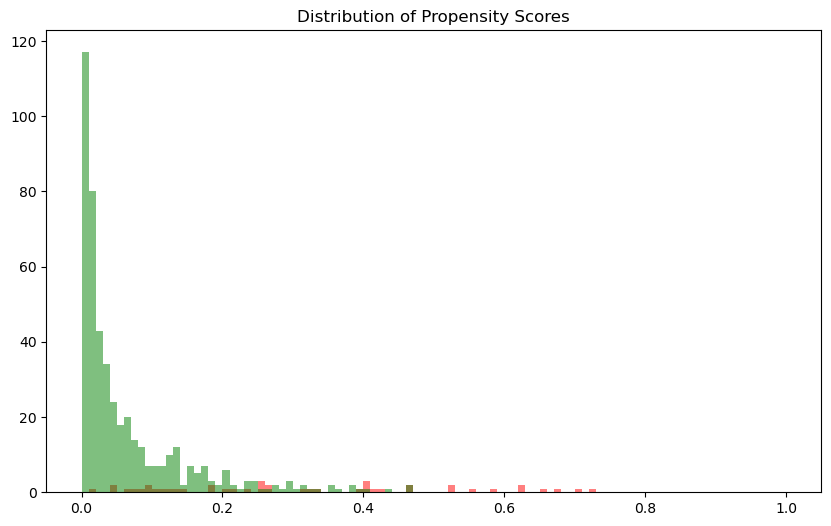

In [5]:
pm = LogisticRegressionPropensityModel( max_iter=100000)
ps = pm.fit_predict(all_patients_confounders_matrix, exposures)
all_patients["propensity_score"] = ps
# Plot distribution of propensity scores (smooth curve not histogram)
plt.figure(figsize=(10, 6))
plt.hist(all_patients[all_patients["cancer"] == True]["propensity_score"], bins=np.arange(0, 1.01, 0.01), density=False, alpha=0.5, color='r')
plt.title("Distribution of Propensity Scores")
plt.hist(all_patients[all_patients["cancer"] == False]["propensity_score"], bins=np.arange(0, 1.01, 0.01), density=False, alpha=0.5, color='g')


In [13]:
all_samples_microbiome = pd.read_csv("../data/mzmine_data_from_jasmine/15405_20240521-083236.txt", sep="\t")
available_microbiome_participants = all_samples_microbiome[(all_samples_microbiome["age_impute"] != "not applicable") & (all_samples_microbiome["tube_id"] != "none")].drop_duplicates(subset=["participantid"])

all_samples_metabolomics = pd.read_csv("../data/mzmine_data_from_jasmine/Plusrise_Metadata_abstract.csv")

microbiome_metabolome_patients = list(set(available_microbiome_participants["participantid"].to_list()) & set(all_samples_metabolomics["ATTRIBUTE_participantid"].to_list()))

In [26]:
# Get the nearest propensity score for each patient with cancer = True
def find_nearest_propensity_score(patient_dataframe, with_replacement=True):
    patient_dataframe_copy = patient_dataframe.copy()
    # Sort the dataframe by propensity score
    patient_dataframe = patient_dataframe.sort_values(by="propensity_score")
    patient_dataframe_copy = patient_dataframe_copy.sort_values(by="propensity_score")
    for i, row in patient_dataframe.iterrows():
        if row["cancer"] == True:
            # Get the propensity score of the patient
            propensity_score = row["propensity_score"]
            # Find the nearest neighbor with cancer = False
            nearest_neighbor = patient_dataframe_copy[patient_dataframe_copy["cancer"] == False].iloc[(patient_dataframe_copy[patient_dataframe_copy["cancer"] == False]["propensity_score"] - propensity_score).abs().argsort()[:1]]

            if not with_replacement:
                # Remove the matched patient from the dataframe
                patient_dataframe_copy = patient_dataframe_copy.drop(nearest_neighbor.index)
            patient_dataframe.at[i, "nearest_patient"] = nearest_neighbor["participantid"].values[0]
            # Add difference in propensity score (absolute):
            patient_dataframe.at[i, "absolute_propensity_difference"] = abs(nearest_neighbor["propensity_score"].values[0] - propensity_score)
        else:
            # Add NaN for patients with cancer = False
            patient_dataframe.at[i, "nearest_patient"] = np.nan
            patient_dataframe.at[i, "absolute_propensity_difference"] = np.nan

    return patient_dataframe    


all_patients_with_metabolite_and_microbiome = all_patients[all_patients["participantid"].isin(microbiome_metabolome_patients)]
matched_patients_without_replacement = find_nearest_propensity_score(all_patients_with_metabolite_and_microbiome, with_replacement=False)

/tmp/ipykernel_17580/1400400600.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'UA084' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  patient_dataframe.at[i, "nearest_patient"] = nearest_neighbor["participantid"].values[0]


In [32]:
matched_patients_without_replacement[matched_patients_without_replacement["cancer"]==True].to_csv("../output_data/matched_cancer_patients_without_replacement.csv", index=False)

In [ ]:
matched_patients_without_replacement.to_csv("../output_data/matched_patients_without_replacement.csv", index=False)